# Bikes Dataset

This is documentation about bike data from 10/17 to 11/11.
* `stations_and_traffic.csv`: Describes each bike station and nearby traffic routes. Keyed by `station_id`.
* `per_station/*.csv`: Each file is a dataset grouped to a single bike station. The file name is the `station_id`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read station information too
stations = pd.read_csv('stations_and_traffic.csv')
print(stations.columns)
stations[stations['name'].str.contains('Pershing Square')][stations.columns[:9]]

Index(['capacity', 'eightd_has_key_dispenser', 'lat', 'lon', 'name',
       'region_id', 'rental_methods', 'short_name', 'station_id',
       'traffic_0_distance', 'traffic_0_lat', 'traffic_0_linkId',
       'traffic_0_linkName', 'traffic_0_lon', 'traffic_1_distance',
       'traffic_1_lat', 'traffic_1_linkId', 'traffic_1_linkName',
       'traffic_1_lon', 'traffic_2_distance', 'traffic_2_lat',
       'traffic_2_linkId', 'traffic_2_linkName', 'traffic_2_lon'],
      dtype='object')


,capacity,eightd_has_key_dispenser,lat,lon,name,region_id,rental_methods,short_name,station_id
271,59,False,40.751581,-73.977910,Pershing Square South,71,"['KEY', 'CREDITCARD']",6432.08,517
273,61,True,40.751873,-73.977706,Pershing Square North,71,"['KEY', 'CREDITCARD']",6432.09,519


## Station Data

Description of columns in `stations_and_traffic.csv`:

* `capacity`: # of bike docks
* `eightd_has_key_dispenser`: Unknown
* `lat`, `lon`: Location of station
* `name`: Bike station name
* `region_id`: Unknown
* `station_id`: ID of station found in the bikes per-5-minute dataset
* For $i = 0,1,2$:
  * `traffic_` $i$ `_distance`: Distance to the $i$-th nearest traffic sensor
  * `traffic_` $i$ `_linkId`: Route ID of the $i$-th nearest sensor in the traffic DB
  * `traffic_` $i$ `_linkName`: Name of the $i$-th nearest traffic route with speed data
  * `traffic_` $i$ `_lat/lon`: Location of the $i$-th nearest traffic sensor

## Bikes Data

For example, let's load the Pershing Square North station (`id: 519`):

In [17]:
ps_north = pd.read_csv('per_station/519.csv')
print('Length:', len(ps_north))
print(ps_north.columns)
ps_north['last_reported'] = pd.to_datetime(ps_north['last_reported'], infer_datetime_format=True)
ps_north['weather_ts'] = pd.to_datetime(ps_north['weather_ts'], unit='s')
ps_north['traffic_0_asof'] = pd.to_datetime(ps_north['traffic_0_asof'], infer_datetime_format=True)
ps_north['traffic_1_asof'] = pd.to_datetime(ps_north['traffic_1_asof'], infer_datetime_format=True)
ps_north['traffic_2_asof'] = pd.to_datetime(ps_north['traffic_2_asof'], infer_datetime_format=True)

Length: 4789
Index(['Unnamed: 0', 'eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time', 'y_10m',
       'y_15m', 'y_30m', 'y_45m', 'y_60m', 'y_90m', 'y_120m'

Description of columns:

* **Bike station info**
    * `last_reported`: Timestamp of this record
    * `num_bikes_available`: # of bikes in the station that can be rented
    * `num_docks_available`: # of bike docks in the station that accepts bike returns
    * `num_bikes/docks_disabled`: Opposite of previous 2 columns
    * `is_installed/renting/returning`: Whether the bike station is active.
    * `eightd_has_available_keys`: Unknown
    * `station_id`: Numeric ID of the station (see `stations_and_traffic.csv`)
* **Weather info**
    * `weather_ts`: Timestamp when weather data is taken
    * `apparentTemperature`: "Feels like" temperature
    * `precipType`: Categorical type of precipitation (rain, snow etc). Currently only has "rain" or "none"
    * Other features seem self-explanatory
* **Traffic info**
    * NYC captures traffic based on a specific route (for example, "FDR Drive"). Each route has multiple speed cameras that are spaced evenly along the route. Each route outputs one speed value.
    * The traffic features are from the 3 nearest speed cameras that belong to different routes.
    * `traffic_i_speed`: The speed measurement. ($i = 0, 1, 2$)
    * `traffic_i_asof`: When this speed measurement was taken.
    * `traffic_i_distance`: How far this speed camera is from the bike station.
* **Target variables** (`y_10m`, ..., `y_120m`)
    * Each target variable is a result of computing `bikes_avail / (bikes_avail + docks_avail)` X minutes into the future.
    * To get actual numbers, find the earliest row that's near to the desired timestamp. "Near" means at least 1 minute before the desired time up to 5 minutes after.
    * For example, the current row has `last_reported = 19:03`. To get `y_60m`, find the earliest row with `last_reported` between `20:02` and `20:08`.
    * Bike stations aren't update continuously (there are some downtimes), so a row falling inside that time period isn't guaranteed. When there's no such row, `y = -1.0`.

# Analysis

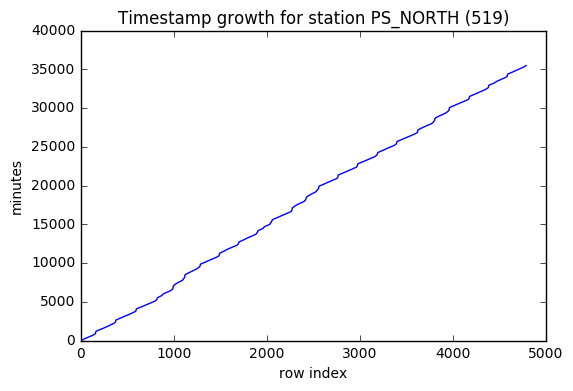

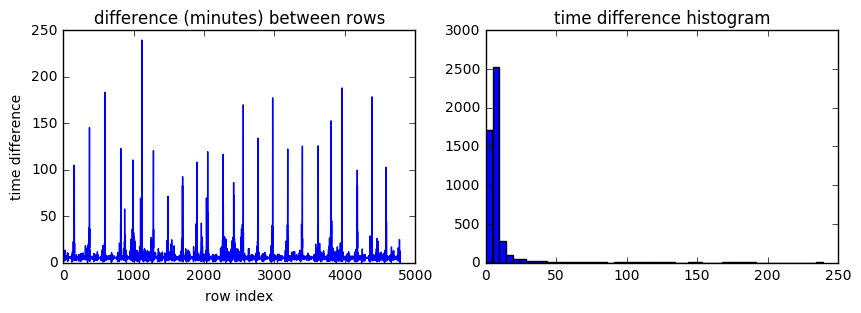

In [18]:
ts = ps_north['last_reported'].as_matrix()
time_growth_m = (ts - ts[0]) / np.timedelta64(1, 'm')
time_delta_m = np.diff(ts) / np.timedelta64(1, 'm')

plt.figure()
plt.plot(time_growth_m)
plt.ylabel('minutes')
plt.xlabel('row index')
plt.title('Timestamp growth for station PS_NORTH (519)')
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(time_delta_m)
plt.xlabel('row index')
plt.ylabel('time difference')
plt.title('difference (minutes) between rows')

plt.subplot(1, 2, 2)
plt.hist(time_delta_m, 50)
plt.title('time difference histogram')

plt.show()

As we can see from the plots, there are sometimes large gaps between station updates. This is why some output variables are missing.

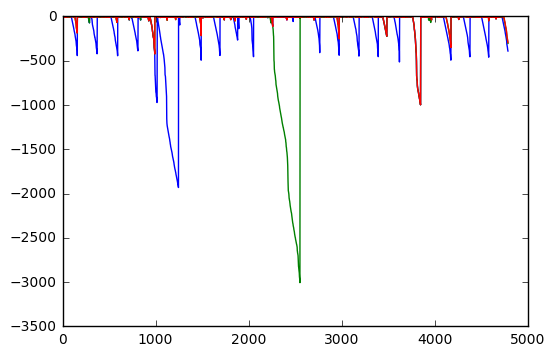

In [48]:
t0 = ps_north['traffic_0_asof'].as_matrix()
t1 = ps_north['traffic_1_asof'].as_matrix()
t2 = ps_north['traffic_2_asof'].as_matrix()

delta_t0 = (t0 - ts) / np.timedelta64(1, 'm')
delta_t1 = (t1 - ts) / np.timedelta64(1, 'm')
delta_t2 = (t2 - ts) / np.timedelta64(1, 'm')

plt.figure()
plt.plot(delta_t0)
plt.plot(delta_t1)
plt.plot(delta_t2)
plt.show()

It turns out traffic data does get stale sometimes. If we remove traffic data that's too stale:

In [49]:
print(len(ps_north))

nonstale = (delta_t0 > -15) & (delta_t1 > -15) & (delta_t2 > -15)
print(sum(nonstale))

y30 = ps_north['y_30m'] >= 0
print(sum(y30))

print(sum(nonstale & y30))

4789
2911
3899
2558


Meaning, only half of the dataset contains current data and has a target variable.